In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors
import healpy as hp
import math
from shapely.geometry import Point, Polygon

These are the imports needed for this algorithm

In [25]:
def main(order):
  
    # Create points for sphere
    theta = np.linspace(0, 2 * np.pi, 100)
    phi = np.linspace(0, np.pi, 50)
    theta, phi = np.meshgrid(theta, phi)
    r = 1
    
    # Convert to Cartesian coordinates
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    
    # Plot sphere
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap = mcolors.ListedColormap(['white']), alpha=0.4)
    
    arc_lengths = dict()
    #Do one pixel at a time
    for i in range(hp.order2npix(order)):
        #Get Boundary points
        points = getBoundaries(order, i)
        #Plot Boundary points
        ax.scatter(points[0], points[1], points[2], c='red', s=25)
    
    
        
        #Get Arc Values
        arc12, arc23, arc34, arc41 = getArcs(points)
        # Plot the arcs
        ax.scatter(arc12[:, 0], arc12[:, 1], arc12[:, 2], color='blue', s = 2)
        ax.scatter(arc23[:, 0], arc23[:, 1], arc23[:, 2], color='blue', s =2)
        ax.scatter(arc34[:, 0], arc34[:, 1], arc34[:, 2], color='blue', s =2)
        ax.scatter(arc41[:, 0], arc41[:, 1], arc41[:, 2], color='blue', s = 2)

    # # ax.scatter(arc12[40, 0], arc12[40, 1], arc12[40, 2], color='green', s = 100)

        
        #Get Values in Pixel
        new_points, arc_length= getPoints(arc12, arc23, arc34, arc41)
        #Plot Values in pixel
        ax.scatter(new_points[:,0], new_points[:,1], new_points[:,2], c=np.random.rand(3,), s=1)
        arc_lengths[i] = arc_length
        # if(i ==2):
        #     ax.scatter(new_points[0:49, 0], new_points[0:49, 1], new_points[0:49, 2], color='green', s = 500)
           
    print(np.shape(new_points))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('HealPix Pixels')
    ax.set_box_aspect((1, 1, 1))
    plt.show()
    return arc_lengths

/tmp/ipykernel_53543/3307281798.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(new_points[:,0], new_points[:,1], new_points[:,2], c=np.random.rand(3,), s=1)


(5000, 3)


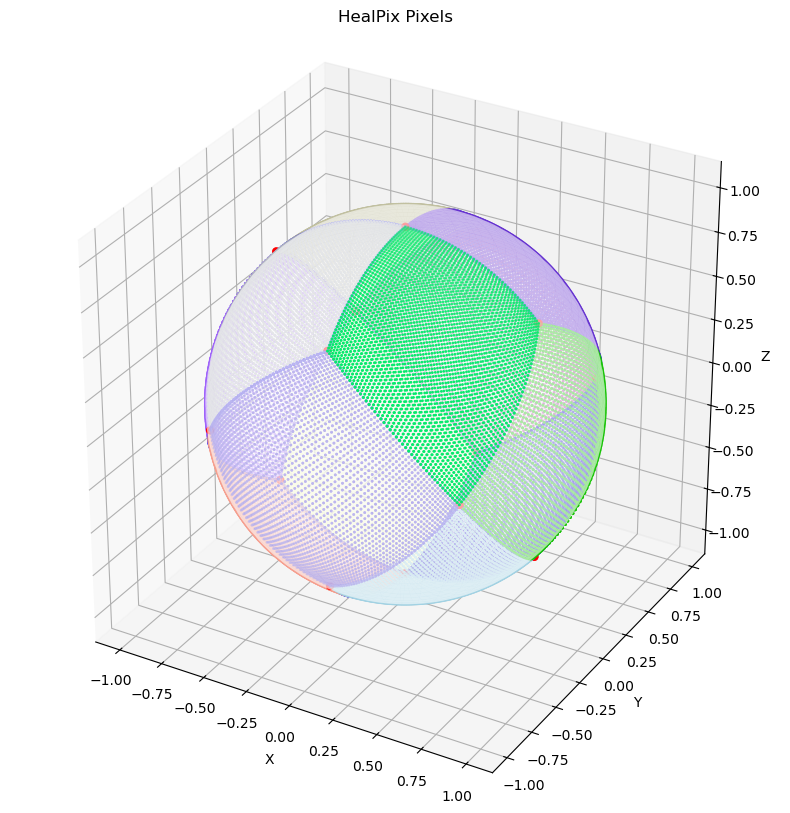

In [26]:

t = main(0)

In [28]:
np.shape(t[0][0])

(49,)

In [30]:
t[0][0]

array([0.87744686, 0.88912772, 0.90060669, 0.91185584, 0.92284663,
       0.93354998, 0.94393649, 0.95397652, 0.96364042, 0.97289868,
       0.98172213, 0.99008214, 0.99795084, 1.00530131, 1.01210781,
       1.01834597, 1.02399302, 1.02902797, 1.03343182, 1.03718769,
       1.04028104, 1.04269976, 1.04443432, 1.04547783, 1.04582613,
       1.04547783, 1.04443432, 1.04269976, 1.04028104, 1.03718769,
       1.03343182, 1.02902797, 1.02399302, 1.01834597, 1.01210781,
       1.00530131, 0.99795084, 0.99008214, 0.98172213, 0.97289868,
       0.96364042, 0.95397652, 0.94393649, 0.93354998, 0.92284663,
       0.91185584, 0.90060669, 0.88912772, 0.87744686])

In [35]:
np.shape(t[0])

(100, 49)

In [34]:
np.mean(t[1])

1.161465762158933

In [36]:
np.mean(t[0])

1.1614657621589344

In [37]:
np.mean(t[2])

1.161465762158933

In [38]:
np.mean(t[9])

1.1614657621589377

In [39]:
np.mean(t[5])

1.3068382426739882

In [57]:
np.std(t[2])

0.11763286332816264

In [56]:
np.std(t[5])

0.14334818277313316

In [58]:
np.std(t[8])

0.117632863328162

The Mean, Max, Min, STD for 0-3 and 8-11 are the same, then 4-7 are higher

The Main method can be run at different orders

In [16]:
def getBoundaries(order, i):
    x_coor = []
    y_coor = []
    z_coor = []
    # for i in range(hp.order2npix(order)):
    test = hp.boundaries(hp.order2nside(order), i, step=1)
    x_coor.extend(test[0])
    y_coor.extend(test[1])
    z_coor.extend(test[2])
        
    return x_coor, y_coor, z_coor

The getBoundaries function is used to get the corners of a specific healpix pixel 

In [17]:
def getArcs(points):
    
    p1, p2, p3, p4= np.transpose(points)
    arc12 = great_circle_arc(p1, p2)
    arc23 = great_circle_arc(p2, p3)
    arc34 = great_circle_arc(p3, p4)
    arc41 = great_circle_arc(p4, p1)
    
    return arc12, arc23, arc34, arc41

The getArcs function returns the great arcs between all the pixel corners

In [18]:
def getPoints(arc12, arc23, arc34, arc41, num_points = 50):
    new_points = []
    all_arc_lengths = []
    
    #This function returns arcs both from top to bottom as well as side to side
    for i in range(num_points):
        arc = great_circle_arc(arc12[i], arc34[num_points - 1 - i])
        new_points.extend(arc)
        arc_lengths=[]
        for j in range(49):
            arc_lengths.append(angle_finder(arc[j], arc[j+1]))
        all_arc_lengths.append(arc_lengths)
    for i in range(num_points):
        arc = great_circle_arc(arc23[i], arc41[num_points -1 - i])
        new_points.extend(arc)
        arc_lengths=[]
        for j in range(49):
            arc_lengths.append(angle_finder(arc[j], arc[j+1]))
        all_arc_lengths.append(arc_lengths)


    

                
                    
    return np.array(new_points), np.array(all_arc_lengths)

The getPoints function is used to find arcs between the boundary arcs of the pixel

In [19]:
def great_circle_arc(p1, p2, num_points=50):
    """Generates points along a great circle arc between two points."""
    p1_norm = p1 / np.linalg.norm(p1)
    p2_norm = p2 / np.linalg.norm(p2)
    points = []
    for i in range(num_points):
        t = i / (num_points - 1)
        # Linear interpolation and normalization
        pt = (1 - t) * p1_norm + t * p2_norm
        pt_norm = pt / np.linalg.norm(pt)
        points.append(pt_norm)
    return np.array(points)

In [20]:
import numpy as np

def arc_length_3d(point1, point2):
    """
    Calculates the arc length between two 3D Cartesian coordinates on a sphere.

    Args:
        point1 (tuple or list): The coordinates of the first point (x, y, z).
        point2 (tuple or list): The coordinates of the second point (x, y, z).
        radius (float): The radius of the sphere.

    Returns:
        float: The arc length between the two points.
    """

    point1 = np.array(point1)
    point2 = np.array(point2)

    # Calculate the angle between the two vectors
    cos_theta = np.dot(point1, point2) / (np.linalg.norm(point1) * np.linalg.norm(point2))
    # Ensure the value is within the valid range for arccos
    cos_theta = np.clip(cos_theta, -1, 1) 
    angle = np.arccos(cos_theta)

    # Calculate the arc length
    arc_length = angle
    return arc_length


In [21]:
def diff_in_angle(p1, p2):
   new_p1 = spherical(p1)
   new_p2 = spherical(p2)
   theta= abs(math.degrees(new_p1[0]) - math.degrees(new_p2[0]))
   phi = abs(math.degrees(new_p1[1]) - math.degrees(new_p2[1]))
   return theta, phi

In [22]:
def spherical(point):
    return np.arctan2(point[1], point[0]), np.arccos(point[2])

In [23]:
import math

def spherical_angle_diff(point1, point2):
    """
    Calculates the difference in theta and phi angles between two points on a sphere given their Cartesian coordinates.

    Args:
        point1: A tuple of length 3 representing the Cartesian coordinates of the first point.
        point2: A tuple of length 3 representing the Cartesian coordinates of the second point.

    Returns:
        A tuple containing the difference in theta and phi angles.
    """
    
    def to_spherical(point):
        x, y, z = point
        r = math.sqrt(x**2 + y**2 + z**2)
        theta = math.atan2(y, x)
        phi = math.acos(z / r)
        return theta, phi

    theta1, phi1 = to_spherical(point1)
    theta2, phi2 = to_spherical(point2)

    return (theta2 - theta1), (phi2 - phi1)

In [24]:
def angle_finder(point1, point2):

    point1 = np.array(point1)
    point2 = np.array(point2)

    # Calculate the dot product of the two vectors
    dot_product = np.dot(point1, point2)

     # Ensure the value is within the valid range for arccos (-1 to 1)
    cos_theta = np.clip(dot_product, -1, 1)
    
    # Calculate the angle in radians using arccos
    angle = math.degrees(math.acos(cos_theta))

    return angle

This function was copied, but it is used to return a specified number of points on great circle arcs between two points